# Euler Equation Simple

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/li-positive-one/NumericalSnippets/docs/notebooks/Euler_Equation-Simple.ipynb)

In [ ]:
!pip install sodshock

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
%matplotlib inline
device='cuda'

Euler Equation:

$$
\begin{split}\rho_t + (\rho u)_x & = 0 \\
(\rho u)_t + (\rho u^2 + p)_x & = 0 \\
E_t + (u (E + p) )_x & = 0.\end{split}
$$

relationship of primitives and conservations:


$$
E=\frac{p}{\gamma-1}+\frac{1}{2}\rho u^2 
$$

or

$$
p=\rho(\gamma-1)e=(\gamma-1)(E-\frac{1}{2}\rho u^2)
$$

In [3]:
def P2C(rho, u, p, gamma=1.4):
    return rho, rho*u, p/(gamma-1)+0.5*rho*u**2

def C2P(rho, mu, E, gamma=1.4):
    return rho,mu/rho,(gamma-1)*(E-0.5*mu**2/rho)

def eulerflux(F, gamma=1.4):
    rho=F[...,0]
    u=F[...,1]/rho
    E=F[...,2]
    p=(gamma-1)*(E-0.5*rho*u*u)
    flux = torch.stack([rho*u,rho*u**2+p,u*(E+p)],-1)
    return flux

def soundspeed(rho,p,gamma=1.4):
    return (gamma*p/rho)**0.5

### Sodtube Problem

The Sod shock tube is a Riemann problem used as a standard test problem in computational hydrodynamics.

reference:

https://astrodoo.github.io/pyds_manual/SodShockTube.html

https://github.com/ibackus/sod-shocktube


In [4]:
import numpy as np
rho = np.array([1.0, 0.125])
u   = np.array([0.0, 0.0])
p   = np.array([1.0, 0.1])
gamma=1.4
_,mu,E=P2C(rho, u, p, gamma=gamma)

Nx=1000
f0=np.zeros((1,Nx,3))
f0[:,:Nx//2,0]=rho[0]
f0[:,:Nx//2,1]=mu[0]
f0[:,:Nx//2,2]=E[0]
f0[:,Nx//2:,0]=rho[1]
f0[:,Nx//2:,1]=mu[1]
f0[:,Nx//2:,2]=E[1]

In [5]:
def Riemann_LF(F,hn,hp,a):
    return 0.5*(F(hn)+F(hp)-torch.abs(a)*(hp-hn))
    
def pad_constant(q):
    qpad=F.pad(q.unsqueeze(0),[0,0,1,1],mode='replicate').squeeze(0)
    return qpad

In [6]:
%%time
t=0
q=torch.from_numpy(f0).to(device=device)
CFL=0.9
dx=1/Nx
gamma=1.4
while t<0.2:
    qpad = pad_constant(q)
    rho,mu,E = qpad[...,0],qpad[...,1],qpad[...,2]
    u=mu/rho
    p=(gamma-1)*(E-0.5*rho*u**2)
    a0 = (soundspeed(rho,p,gamma)+u.abs()).max()
    dt= CFL * dx / a0
    f = Riemann_LF(lambda x:eulerflux(x,gamma=gamma),qpad[:,:-1,:],qpad[:,1:,:],a0)
    flux= (f[:,:-1,:]-f[:,1:,:])/dx
    q = q+flux*dt
    t = t+dt
q=q.cpu().numpy()
rho, u, p=C2P(q[0,...,0],q[0,...,1],q[0,...,2],gamma=1.4)

CPU times: user 1.91 s, sys: 1.11 s, total: 3.03 s
Wall time: 3.02 s


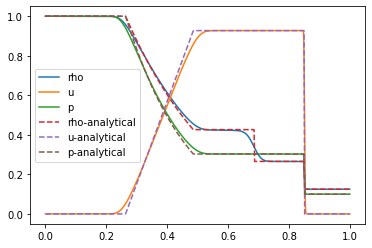

In [7]:
plt.plot(np.linspace(0,1,1000),rho,label='rho')
plt.plot(np.linspace(0,1,1000),u,label='u')
plt.plot(np.linspace(0,1,1000),p,label='p')

import sodshock

gamma = 1.4
dustFrac = 0.0
npts = 500
t = 0.2
left_state = (1,1,0)
right_state = (0.1, 0.125, 0.)

positions, regions, values = sodshock.solve(left_state=left_state, \
    right_state=right_state, geometry=(0., 1., 0.5), t=t, 
    gamma=gamma, npts=npts, dustFrac=dustFrac)

plt.plot(values['x'], values['rho'], "--",label='rho-analytical')
plt.plot(values['x'], values['u'], "--",label='u-analytical')
plt.plot(values['x'], values['p'], "--",label='p-analytical')
plt.legend()